In [2]:
import json

with open('data/processed/penal_code_chunks.json', 'r', encoding='utf-8') as f:
    chunks = json.load(f)

print(f'Loaded {len(chunks)} chunks from JSON file.')
print("First chunk preview:", chunks[0][:500])  # show a preview of the first chunk


Loaded 321 chunks from JSON file.
First chunk preview: قانون العقوبات

مرسوم اشتراعي رقم 340- صادر في1/3/ 1943

إن رئيس الجمهورية اللبنانية،
بناء على تصريح 26 تشرين الثاني سنة 1941 ،
وبناء على اقتراح وزير العدلية،
وبناء على قرار مجلس الوزراء تاريخ 27 شباط سنة 1943 ،
يرسم ما يأتي:

-مةالأحكام العا الكتاب الأول

-في الشريعة الجزائية الباب الأول

-في تطبيق الشريعة الجزائية من حيث الزمان الفصل الأول

النبذة
1- في شريعة الجرائم

المادة1- لا تفرض عقوبة ولا تدبير احترازي أو إصلاحي من أجل جرم لم يكن القانون قد نص عليه
حين اقترافه.
ه الأفعال التي تؤلف الجرم 


In [3]:
from sentence_transformers import SentenceTransformer

# load json

# load multi-lingual model
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

# test on one chunk
example_embedding = model.encode(chunks[0])
print("Example embedding shape:", example_embedding.shape)

Example embedding shape: (384,)


In [4]:
import numpy as np
from tqdm import tqdm

embeddings = [model.encode(chunk) for chunk in tqdm(chunks)]

embeddings = np.array(embeddings)
print("✅ Embeddings array shape:", embeddings.shape)


100%|██████████| 321/321 [00:06<00:00, 47.52it/s]

✅ Embeddings array shape: (321, 384)


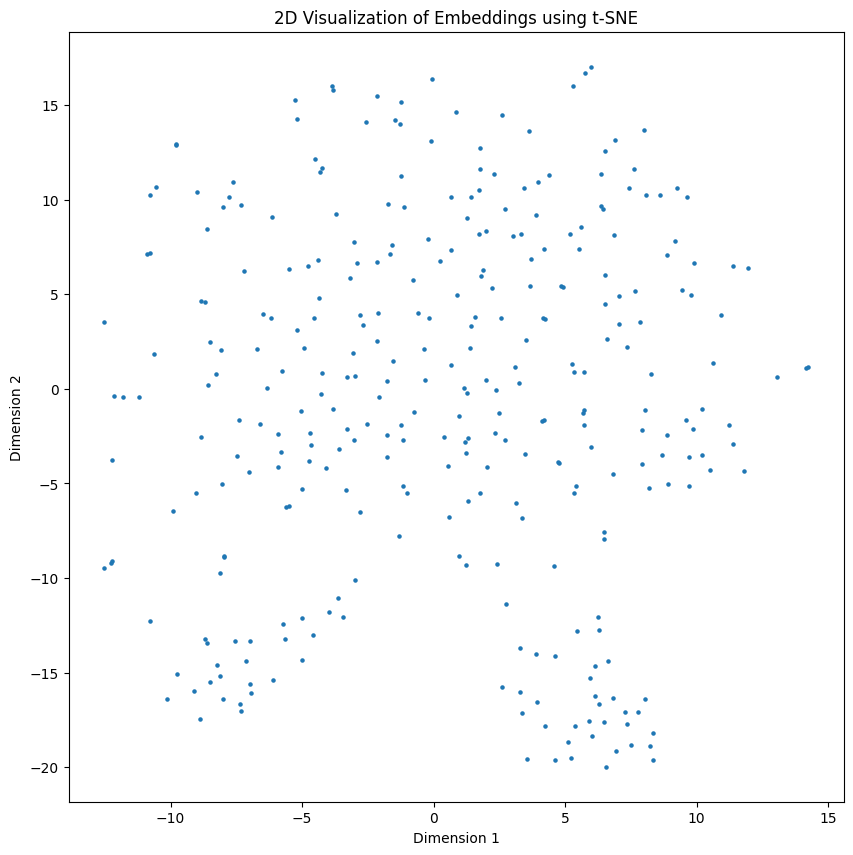

In [5]:
# visualize embeddings on 2d chart
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=5)
plt.title('2D Visualization of Embeddings using t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [6]:
# Manual semantic search (using cosine similarity)
from sklearn.metrics.pairwise import cosine_similarity

def semantic_search(query, model, embeddings,  chunks, top_k=5):

    query_embedding = model.encode([query])
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    top_indices = np.argsort(similarities)[::-1][:top_k]
    results = [(chunks[i], similarities[i]) for i in top_indices]
    return results

In [7]:
query = "ما هي العقوبة على السرقة؟"

results = semantic_search(query, model, embeddings, chunks, top_k=3)

for i, (text, score) in enumerate(results, 1):
    print(f"\n🔹 النتيجة {i} (التشابه = {score:.3f}):\n{text[:500]}")



🔹 النتيجة 1 (التشابه = 0.836):
شخص مقنع أو يحمل سلاحا ظاهرا أو خفيا ب .
6- إذا وقعت السرقة باستعمال العنف على الأشخاص.

المادة 639- معدلة وفقا للقانون487 تاريخ8/12/ 1995
يعاقب بالأشغال الشاقة من ثلاث سنوات إلى سبع سنوات كل من يرتكب السرقة في إحدى الحالات الآتية:
1- و الكسر في الأماكن المقفلة المصانة بالجدران، مأهولة أم غير مأهولة، أو يتسلقها في بواسطة الخلع أ
الداخل أو الخارج أو باستعمال المفاتيح المصنعة أو أي أداة أخرى أو بعد الدخول إليها بالحيلة أو بانتحال
صفة موظف أو بالتذرع بمهمة رسمية أو بأي طريقة أخرى غير مألوفة.
2- قوع

🔹 النتيجة 2 (التشابه = 0.777):
 أو قسم من عقار، بقصد السكن أو الأشغال أو الاستثمار أو من استولى دون مسوغ شرعي عل
الاستعمال لأي غاية أخرى، يعاقب بالحبس من شهر إلى سنة وبالغرامة من مائتي ألف إلى مليون ليرة.
تشدد العقوبة وفقا للمادة 257 في كل من الحالات التالية:
1- لأشياءإذا رافق الفعل تهديد أو عنف على الأشخاص أو ا.
2- إذا وقع الاستيلاء على بناء تشغله إحدى إدارات الدولة أو إحدى الهيئات الإدارية أو إحدى المؤسسات
العامة أو ذات المنفعة العامة.
3- إذا لم يبادر الفاعل إ

In [8]:
# Chroma vector database
import chromadb
from chromadb.utils import embedding_functions

chroma_client = chromadb.PersistentClient(path="data/embeddings/chroma_db")

collection = chroma_client.get_or_create_collection(name="lebanese_penal_code")

In [9]:
# Add data to Chroma
# convert embeddings to list of lists
embeddings_list = embeddings.tolist()

# generate unique IDs for each chunk
ids = [f"chunk_{i}" for i in range(len(chunks))]

# Add data to Chroma
collection.add(
    ids=ids,
    embeddings=embeddings_list,
    documents=chunks   
)
print("✅ Added:", len(chunks), "chunks to Chroma database.")

✅ Added: 321 chunks to Chroma database.


In [10]:
query = "ما هي العقوبة على السرقة؟"

results = collection.query(
    query_texts=[query],
    n_results=3
)

for i, doc in enumerate(results['documents'][0], 1):
    print(f"\n🔹 النتيجة {i}:\n{doc[:500]}")



🔹 النتيجة 1:
كب الجرم:
يات التحليل أو التركيب أو الكيل أو إلى تغيير بقصد الغش في إما بدسائس أو بوسائل ترمي إلى إفساد عمل
تركيب البضاعة أو وزنها أو حجمها حتى قبل إجراء هذه العمليات.
وإما ببيانات مغشوشة ترمي إلى الإقناع بوجود عملية سابقة صحيحة.

النبذة 3- في عرقلة حرية البيوع بالمزايدة

المادة 684- معدلة وفقا للمرسوم الاشتراعي 112 تاريخ16/9/ 1983 والقانون239 تاريخ
27/5/ 1993
كل من أقدم أثناء مزايدة علنية على عرقلة حرية المزايدة أو الالتزامات وذلك بالتهديد أو العنف أو
الأكاذيب أو على إقصاء المتزايدين والملتزمين

🔹 النتيجة 2:
نه التأثير في نفس المجنى عليه تأثيرا شديدا يعاقب عليه، بناء على الشكوى، بغرامة لا تتجاوز
المئة ألف ليرة.

النبذة 4- في إفشاء الأسرار

المادة 579- معدلة وفقا للمرسوم الاشتراعي112 تاريخ16/9/ 1983 والقانون239 تاريخ
27/5/ 1993
من كان بحكم وضعه أو وظيفته أو مهنته أو فنه، على علم بسر وأفشاه دون سبب شرعي أو استعمله
لأكثر وبغرامة لا تتجاوز الأربعمائة ألف ليرة إذا لمنفعته الخاصة أو لمنفعة آخر عوقب بالحبس سنة على ا
كان الفعل من شأنه أن يسبب ضررا ولو معنويا .

المادة 580- يعاقب

In [11]:
from chromadb.utils import embedding_functions

arabic_embedder = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

chroma_client = chromadb.PersistentClient(path="data/embeddings/chroma_db")

# Create a NEW collection name (avoid conflict)
collection = chroma_client.get_or_create_collection(
    name="lebanese_penal_code_arabic",
    embedding_function=arabic_embedder
)

print("✅ New Arabic-compatible collection created.")


✅ New Arabic-compatible collection created.


In [12]:
collection.add(
    ids=[f"chunk_{i}" for i in range(len(chunks))],
    documents=chunks
)
print("✅ Added", len(chunks), "chunks using Arabic embedding model.")


✅ Added 321 chunks using Arabic embedding model.


In [13]:
query = "ما هي العقوبة على السرقة؟"

results = collection.query(
    query_texts=[query],
    n_results=3
)

for i, doc in enumerate(results['documents'][0], 1):
    print(f"\n🔹 النتيجة {i}:\n{doc[:500]}")



🔹 النتيجة 1:
شخص مقنع أو يحمل سلاحا ظاهرا أو خفيا ب .
6- إذا وقعت السرقة باستعمال العنف على الأشخاص.

المادة 639- معدلة وفقا للقانون487 تاريخ8/12/ 1995
يعاقب بالأشغال الشاقة من ثلاث سنوات إلى سبع سنوات كل من يرتكب السرقة في إحدى الحالات الآتية:
1- و الكسر في الأماكن المقفلة المصانة بالجدران، مأهولة أم غير مأهولة، أو يتسلقها في بواسطة الخلع أ
الداخل أو الخارج أو باستعمال المفاتيح المصنعة أو أي أداة أخرى أو بعد الدخول إليها بالحيلة أو بانتحال
صفة موظف أو بالتذرع بمهمة رسمية أو بأي طريقة أخرى غير مألوفة.
2- قوع

🔹 النتيجة 2:
 أو قسم من عقار، بقصد السكن أو الأشغال أو الاستثمار أو من استولى دون مسوغ شرعي عل
الاستعمال لأي غاية أخرى، يعاقب بالحبس من شهر إلى سنة وبالغرامة من مائتي ألف إلى مليون ليرة.
تشدد العقوبة وفقا للمادة 257 في كل من الحالات التالية:
1- لأشياءإذا رافق الفعل تهديد أو عنف على الأشخاص أو ا.
2- إذا وقع الاستيلاء على بناء تشغله إحدى إدارات الدولة أو إحدى الهيئات الإدارية أو إحدى المؤسسات
العامة أو ذات المنفعة العامة.
3- إذا لم يبادر الفاعل إلى ترك العقار وإخلائه ضمن مهلة أسبوع

In [14]:
def retrieve_context(query: str, top_k: int = 3):
    """Return (id, similarity, document) for the top_k results."""
    res = collection.query(
        query_texts=[query],
        n_results=top_k,
        include=["documents", "distances"]   # <- removed "ids"
    )
    docs = res["documents"][0]
    dists = res["distances"][0]              # smaller = closer
    ids   = res["ids"][0]                    # always returned (no need to include)

    # Convert distance to a readable similarity (cosmetic)
    sims = [1 - d for d in dists]
    return list(zip(ids, sims, docs))

# quick test
query = "ما هي العقوبة على السرقة؟"
results = retrieve_context(query, top_k=3)
for i, (cid, sim, doc) in enumerate(results, 1):
    print(f"\n— النتيجة {i} | id={cid} | شبه={sim:.3f}\n{doc[:500]}")



— النتيجة 1 | id=chunk_259 | شبه=0.836
شخص مقنع أو يحمل سلاحا ظاهرا أو خفيا ب .
6- إذا وقعت السرقة باستعمال العنف على الأشخاص.

المادة 639- معدلة وفقا للقانون487 تاريخ8/12/ 1995
يعاقب بالأشغال الشاقة من ثلاث سنوات إلى سبع سنوات كل من يرتكب السرقة في إحدى الحالات الآتية:
1- و الكسر في الأماكن المقفلة المصانة بالجدران، مأهولة أم غير مأهولة، أو يتسلقها في بواسطة الخلع أ
الداخل أو الخارج أو باستعمال المفاتيح المصنعة أو أي أداة أخرى أو بعد الدخول إليها بالحيلة أو بانتحال
صفة موظف أو بالتذرع بمهمة رسمية أو بأي طريقة أخرى غير مألوفة.
2- قوع

— النتيجة 2 | id=chunk_302 | شبه=0.777
 أو قسم من عقار، بقصد السكن أو الأشغال أو الاستثمار أو من استولى دون مسوغ شرعي عل
الاستعمال لأي غاية أخرى، يعاقب بالحبس من شهر إلى سنة وبالغرامة من مائتي ألف إلى مليون ليرة.
تشدد العقوبة وفقا للمادة 257 في كل من الحالات التالية:
1- لأشياءإذا رافق الفعل تهديد أو عنف على الأشخاص أو ا.
2- إذا وقع الاستيلاء على بناء تشغله إحدى إدارات الدولة أو إحدى الهيئات الإدارية أو إحدى المؤسسات
العامة أو ذات المنفعة العامة.
3- إذا ل

In [ ]:
def build_context_block(hits):
    """Format retrieved chunks into a readable, cited context block."""
    lines = []
    for cid, sim, doc in hits:
        # keep each context item compact; trim very long chunks
        snippet = doc.strip()
        if len(snippet) > 1200:
            snippet = snippet[:1200] + "…"
        lines.append(f"[{cid}] {snippet}")
    return "\n\n".join(lines)

def build_prompt_ar(question: str, context_block: str) -> str:
    system_instructions = (
        "أنت مساعد قانوني يعتمد فقط على النص المقدم في قسم (السياق). "
        "أجب باللغة العربية الفصحى بشكل واضح ومحدد، واذكر مواد القانون مع الاستشهاد بمعرّفات المقاطع بين أقواس مربعة. "
        "إذا لم تجد جواباً في السياق، قل: (لا يوجد في النص المقدم ما يجيب بدقة). لا تفترض معلومات خارج السياق."
    )
    user_template = (
        f"السؤال:\n{question}\n\n"
        f"السياق (مقاطع مسترجعة من قانون العقوبات اللبناني):\n{context_block}\n\n"
        "المطلوب:\n"
        "- قدّم إجابة موجزة ودقيقة.\n"
        "- أدرج الاستشهادات مثل [chunk_12] في نهاية الجمل ذات الصلة.\n"
        "- إن كان هناك أكثر من مادة، قدّمها على شكل نقاط.\n"
    )
    prompt = f"{system_instructions}\n\n{user_template}"
    return prompt

# test-build the prompt (no model call yet)
ctx = build_context_block(results)
prompt = build_prompt_ar(query, ctx)
print(prompt[:1200])


In [27]:
from huggingface_hub import InferenceClient
import os
from dotenv import load_dotenv

load_dotenv()
print("✅ Key loaded:", os.getenv("OPENAI_API_KEY")[:10], "...")


✅ Key loaded: sk-proj--0 ...


In [28]:
from openai import OpenAI

client = OpenAI()


In [30]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0.2
)

answer = response.choices[0].message.content
print("🧾 الجواب:\n")
print(answer)


🧾 الجواب:

تعاقب السرقة بالأشغال الشاقة من ثلاث سنوات إلى سبع سنوات في حالات معينة، مثل الكسر في الأماكن المقفلة أو استخدام العنف أو التهديد بالسلاح. وفي الحالات التي لم تحدد لها عقوبة خاصة، تعاقب بالحبس من شهرين إلى ثلاث سنوات وبغرامة من مئة ألف إلى أربعمائة ألف ليرة. [المادة 639، المادة 636]
